# Minimizing functions - how a computer learns

In the previous notebooks, we've seen that by changing **parameters** in a function, we could find a "best fit" of that function to some data. We use a **loss function** to quantify the "goodness" of a set of parameters and we look for those parameters that **optimize**, in fact **minimize**, the loss function. If we teach a machine how to minimize the loss function on its own, we say that machine is able to **learn** how to model our data.

In the last notebook, we threw around terms like **derivative**, **gradient**, and **gradient descent** to give you a rough sense of how we minimize a function on a computer. In this notebook, we will step through these concepts more carefully, with the aim of being able to implement them using Julia.

## Minimizing a 1D function using calculus

Let's draw the 1D loss function $L_1$ from a previous notebook again:

In [5]:
σ(x) = 1 / (1 + exp(-x))
f(x, w) = σ(w * x)

x1 = 2
y1 = 0.8

L1(w) = (y1 - f(x1, w))^2

L1 (generic function with 1 method)

In [6]:
using Plots; gr()
using Interact

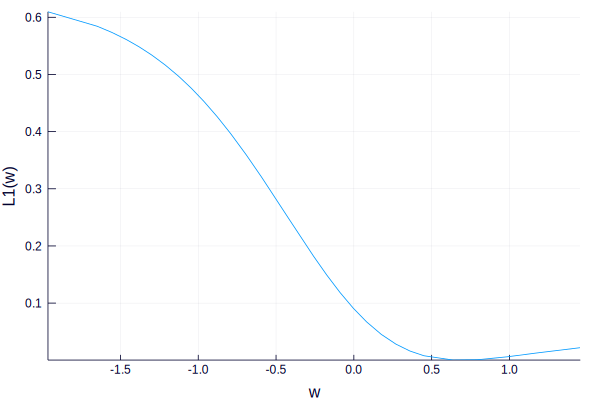

In [7]:
plot(L1, -2, 1.5, xlabel="w", ylabel="L1(w)", leg=false)

By eye, we can see that the minimum is around $w=0.6$. But how can we get the computer to work this out on its own?

In the previous notebook, we thought of this function plot as a hill, viewed from the side. We could find the minimum by making the hill sticky, and letting a ball roll down it. The ball will find and settle in the minimum of the function.  Now let's see how to teach a computer to do this.

We need to find the downhill direction along the hill, which is related to its *slope* (how steep it is). Calculus provides us with tools to calculate that slope!

Namely, the slope of a curve $L_1(w)$ at $w$ is given by its **derivative** $L_1'(w)$; geometrically, this is the slope of the **tangent line** to the curve at that point, i.e. the straight line which touches the curve at that point.

Calculus provides us with some rules to calculate an analytical formula for the derivative, and we will see later how to apply these rules, albeit indirectly, for machine learning. 
To gain understanding, however, we will see here how to get the computer to help us out by calculating the derivatives numerically instead!

## Approximating derivatives

Let's recall that the derivative $L_1'(w)$ of a function is defined as

$$L_1'(w) \simeq \frac{L_1(w+h) - L_1(w)}{h},$$

for a small step size $h$. (Strictly speaking, we must take the limit when $h$ tends to $0$ to obtain the exact value of the derivative.)

#### Exercise 1

Write a function to calculate the derivative of a function at a given point. Note that in Julia, we can easily pass functions as arguments to other functions!
The function should take the function, the point $w$ at which to calculate the derivative, and the value of $h$, which should have a default value of 0.001.

*Note*: A function input argument can have a *default value* if we set the input argument equal to that default value when we define the function. For example,

```julia
f(x, a = 3) = a * x^2
```

The function `f` will square the input we give it and multiply by `a`. However,  if we choose to call `f(x)` *without* passing it an `a` input, it will assume `a` is `3` and return `3*x^2`.

#### Solution

We could define the `derivative` function as

```julia
function derivative(f, w, h=0.001)
    return ( f(w + h) - f(w) ) / h
end
```

or, using the short form for a function definition, 

```julia
derivative(f, w, h=0.001) = ( f(w + h) - f(w) ) / h
```

Here are some tests:
```julia
derivative(x->x^2, 0.2) ≈ 0.401    # check default h works
derivative(x->x^2, 0.2, 0.5) ≈ .9  # check we can specify our own h
derivative(x->x^3, 0.2) ≈ 0.120601
derivative(x->x^3, -0.2) ≈ 0.119401
```

In [11]:
function derivative(f, w, h=0.001)
    return ( f(w + h) - f(w) ) / h
end

derivative (generic function with 2 methods)

#### Exercise 2

Write an interactive visualization of the tangent line to the graph of $L_1$, so that we can visualize the tangent at any point on $L_1$. Include the current value of the derivative in the title.

*Hint*: Recall that the straight line through the point $(x_0, y_0)$ with slope $m$ is given by

$$ \frac{y - y_0}{x - x_0} = m,$$

so 

$$y = y_0 + m*(x - x_0).$$

#### Solution

Interact.Options{:SelectionSlider,Float64}(13: "input-6" = -0.5 Float64 , "w", -0.5, "-0.5", 151, Interact.OptionDict(DataStructures.OrderedDict("-2.0"=>-2.0,"-1.99"=>-1.99,"-1.98"=>-1.98,"-1.97"=>-1.97,"-1.96"=>-1.96,"-1.95"=>-1.95,"-1.94"=>-1.94,"-1.93"=>-1.93,"-1.92"=>-1.92,"-1.91"=>-1.91…), Dict(-0.92=>"-0.92",-0.22=>"-0.22",-1.78=>"-1.78",-1.23=>"-1.23",0.22=>"0.22",-1.16=>"-1.16",0.2=>"0.2",0.89=>"0.89",0.48=>"0.48",-0.8=>"-0.8"…)), Any[], Any[], true, "horizontal", true)

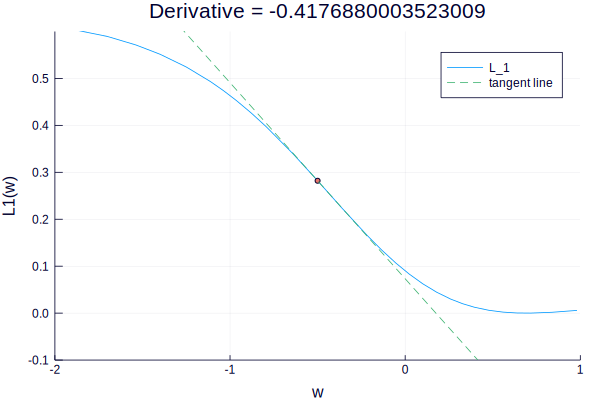

In [13]:
wmin = -2
wmax = 1
w_range = wmin:0.01:wmax

@manipulate for w in w_range
    plot(L1, wmin, wmax, label="L_1")
    
    x0 = w
    y0 = L1(w)
    
    scatter!([x0], [y0], label="")
    
    m = derivative(L1, w)
    
    plot!(x->y0 + m*(x - x0), ls=:dash, label="tangent line")
    
    ylims!(-0.1, 0.6)
    xlims!(wmin, wmax)
    
    title!("Derivative = $m")
    xlabel!("w")
    ylabel!("L1(w)")
end

#### Exercise 3

What is the value of the derivative (slope of the tangent line) at a minimum? Can this happen anywhere else?

#### Solution

The derivative is `0` at a minimum. This happens at any minimum, maximum or "point of inflection" of a smooth function.

## Minimization by gradient descent

The tangent line at a point is a good approximation of the function near that point. Therefore the derivative tells us in which direction, and how fast, a function grows or shrinks when we move a small distance away from that point. 

As we saw in the previous notebook, we can think of the function as being a hill, and having a ball that we want to move down the hill. Gravity will automatically pull the ball in the direction *down* the hill; we want to emulate this in the computer!

#### Exercise 4

When the derivative $L_1'(w)$ is positive, that means that $L_1$ increases from left to right at point $w$.

If the derivative $L_1'(w)$ is positive (> 0), in which direction should we move $w$ to *decrease* $L_1$?

#### Solution

We should move $w$ left, i.e. decrease it.

#### Exercise 5

If the derivative $L_1'(w)$ is negative (< 0), in which direction should we move $w$ to *decrease* $L_1$?

We can use this information to tell the computer which way to take a step. This constitutes the numerical algorithm called **gradient descent**; it is called this since we are descending (moving downwards) along the graph of the function by using information about its gradient (slope).

#### Exercise 6

Implement gradient descent by following this prescription for an **iterative (repetitive) algorithm**:

1. Start at an initial guess $w_0$ for $w$. 

2. At each step, calculate the derivative, $L_1'(w_n)$ at the current value of $w_n$ using the function that you created above.

3. Modify the value of $w$ by a small multiple (for example, $\eta=0.01$) of the value of the derivative you just created, via $w_{n+1} = w_n - \eta L_1'(w_n)$.

For this problem, start with $w_0 = -2.0$. Repeat steps 2 and 3 a total of `2000` times.

Package this code into a function called `gradient_descent` that takes two inputs, a function and a range for values of $w$, and returns the final value of $w$ and $L_1(w)$.

Using `L1` and `-2:0.01:1.5` as your inputs to `gradient_descent`, for what value of $w$ is $L_1$ at a minimum?

#### Solution


Your code should look similar to

```julia
function gradient_descent(f, wrange)
    derivative(f, w, h=0.001) = ( f(w + h) - f(w) ) / h
    w = -2.0
    for i in 1:2000
        fderiv = derivative(f, w)
        step = .01 * fderiv
        w = w - step
    end
    return w, f(w)
end

gradient_descent(C1, -2:0.01:1.5)
```

and should roughly produce `(0.6383448319922364, 0.0003281257939913364)`

#### Test
```julia
0.6383 < gradient_descent(C1, -2:0.01:1.5)[1] < 0.6385
```

#### Exercise 7

Modify your code for gradient descent to return the result once it has found an answer within some *tolerance*, rather than taking a set number of steps. The new prescription for this algorithm is:

1. Start at an initial guess $w_0$ for $w$. 

2. At each step, calculate the derivative, $L_1'(w_n)$ at the current value of $w_n$, using the function that you created above.

3. Modify the value of $w$ by a small multiple (for example, $\eta=0.01$) of the value of the derivative you just created, via $w_{n+1} = w_n - \eta L_1'(w_n)$.

4. Check how different $w_{n+1}$ is from $w_n$. If you're satisfied that $L_1(w_{n+1})$ is minimized, return $w_{n+1}$ and $L_1(w_{n+1})$. Otherwise, go to step (2) and continue.

Edit `gradient_descent` so that it takes three inputs: a function, a range for values of $w$, and a tolerance that tells you how close $w_{n+1}$ must be to $w_n$ before you can stop iterating. 

Using `L1`, `-2:0.01:1.5`, and `.000001` as your inputs to `gradient_descent`, for what value of $w$ is $L_1$ at a minimum?

#### Solution


Your code should look something like

```julia
function gradient_descent(f, wrange, tol)
    w = -2.0
    while true
        fderiv = derivative(f, w)
        step = .01 * fderiv
        w = w - step
        if abs(step) < tol
           return w, f(w) 
        end
    end
end

gradient_descent(C1, -2:0.01:1.5, .000001)
```

$C_1$ is at a minimum when `gradient_descent(C1, -2:0.01:1.5, .000001)[1]`, or $w$, is around `0.69216`.

**Test**
```julia
0.69215 < gradient_descent(C1, -2:0.01:1.5, .000001)[1] < 0.69217
```

After you've completed this step, you will have found a good approximation to the value $w^*$ where $L_1$ reaches its minimum, and the minimum value $L_1(w^*)$, which in this case is (almost) $0$.

#### Exercise 8

Alter the function `gradient_descent` so that it stores the results `(w, L1(w))` at each step of the algorithm as an array and returns this array. How many steps does the algorithm take for input parameters `(L1, -2:0.01:1.5, .000001)` before terminating? You should count your starting $w_0$ as your first step.

#### Solution

Your altered code should look like

```julia
function gradient_descent(f, wrange, tol)
    w = -2.0
    store_w = [(w, f(w))]
    while true
        fderiv = derivative(f, w)
        step = .01 * fderiv
        w = w - step
        push!(store_w, (w, f(w)))
        if abs(step) < tol
           return store_w 
        end
    end
end
```

You can get the number of steps taken via

```julia
length(gradient_descent(C1, -2:0.01:1.5, .000001))
```

This gives the answer `4255` steps.

#### Exercise 9

Overlay the steps taken in the last exercise with a plot of $L_1(w)$ vs. $w$.

Where does our algorithm take the largest steps? (Where does the ball move fastest down the hill?)

A) Between w = -2:-1<br>
B) Between w = -1:0<br>
C) Between w = 0:.6

*Hint*: It may be easier to see what's going on if you only plot, for example, every 15th step.

B) The following code generates the desired figure:

```julia
wsteps = gradient_descent(C1, -2:0.01:1.5, .000001)
fig1 = plot(C1, -2, 1.5, xlabel="w", ylabel="C1(w)", leg=false)
for step in wsteps[1:15:end]
   scatter!([step[1]], [step[2]]) 
end
display(fig1)
```

## Functions of 2 variables and their derivatives

So far, we have been looking at the minimizing a loss function $L_1(w)$ that depends on a single parameter, $w$. Now let's turn to the cost function $L_2(w, b)$ from a previous notebook, that is a function of *two* parameters, $w$ and $b$, and try to minimize it.

As we've seen, we get a **surface**, instead of a curve, when we graph $L_2$ as a function of both of its parameters.

**Exercise 10** 

Draw a surface plot of $L_2$, given by

$$L_{2}(w, b) = \sum_i(y_i - g(x_i, w, b))^2$$

using the `surface` function from `Plots.jl`. For this plot, use the values of `xs` and `ys` from notebook 5:

```julia
xs = [2, -3, -1, 1]
ys = [0.8, 0.3, 0.4, 0.4]
```

We can get a nice interactive 3D plot by using the Plotly backend of `Plots.jl` by executing the command 

    plotly()

#### Solution

The following code will generate the desired graphic:

```julia
plotly()
σ(x) = 1 / (1 + exp(-x))
g(x, w, b) = σ(w*x) + b

xs = [2, -3, -1, 1]
ys = [0.8, 0.3, 0.4, 0.4]

L2(w, b) = sum(abs2, ys .- g.(xs, w, b))

surface(-2:0.02:2, -2:0.02:2, L2, alpha=0.6, xlabel = "w", ylabel = "b", zlabel = "L2(w, b)")
```

### Finding the minimum

We can just about see, by rotating the graph, that $L_2$ has a single minimum. We want to find the values of $w$ and $b$ where this minimum value is reached.

Following what we did for the function $L_1$ above, we expect that we will need to calculate derivatives of $L_2$. Since the function is more complicated, though, the derivatives are too!

It turns out that the right concept is that of the [**gradient**](https://en.wikipedia.org/wiki/Gradient) of $L_2$, denoted $\nabla L_2(w, b)$. This is a **vector** consisting of $2$ numbers if there are $2$ parameters [or, in general, $n$ numbers if there are $n$ parameters].

The numbers that form the gradient $\nabla L_2(w, b)$ are called the **partial derivatives** of $L_2$ with respect to $w$ and $b$,  written as 

$$\frac{\partial L_2}{\partial w} \quad \text{and} \quad \frac{\partial L_2}{\partial b}.$$

Although this notation might look complicated, all it means is that we calculate derivatives just like we did before, except that we fix the value of the other variable. 
For example, to calculate $\frac{\partial L_2}{\partial w}$, the partial derivative of $L_2$ with respect to $w$, we fix the value of $b$ and think of the resulting function as a function of the single variable $w$; then we use the formula for derivatives of functions of a single variable.

[Note that $\frac{\partial L_2}{\partial w}$ is itself a function of $w$ and $b$; we could write $\frac{\partial L_2}{\partial w}(w, b)$.]

#### Exercise 11

Write functions that will allow you to calculate the partial derivatives of a function $f$ of two variables.

In particular, declare functions called `partial_w` and `partial_b`. Each should take four inputs - a function $f$ of two variables, the first input argument to $f$, the second input argument to $f$, and a step size `h` with default value `0.001`. `partial_w` should return the partial derivative of $f$ with respect to its first input argument and `partial_b` should return the partial derivative of $f$ with respect to its second input argument.

#### Solution

The partial derivatives are

```julia
partial_w(f, w, b, h = 0.001) = ( f(w + h, b) - f(w, b) ) / h
partial_b(f, w, b, h = 0.001) = ( f(w, b + h) - f(w, b) ) / h
```

**Tests**

Test that default parameters work:
```julia
@show partial_w((x, y) -> 3 * x * y, 0.3, 0.3) # 0.9
@show partial_b((x, y) -> 3 * x * y, 0.3, 0.3) # 0.9
```

Test that you can specify your own step sizes:
```julia
@show partial_w((x, y) -> 3 * x^2 * y^3, 2.3, 10.2, 1) # 17828.2944
@show partial_b((x, y) -> 3 * x^2 * y^3, 2.3, 10.2, 1) # 5454.8364
```

Test that x and y are treated separately:
```julia
@show partial_w((x, y) -> 3 * x * y^2, 0.3, 0.2) # 0.12
@show partial_b((x, y) -> 3 * x * y^2, 0.3, 0.2) # 0.3609
@show partial_w((x, y) -> 3 * x^2 * y, 0.3, 0.2, 0.1) # 0.42
@show partial_b((x, y) -> 3 * x^2 * y, 0.3, 0.2, 0.1) # 0.27
```

#### Exercise 12

Use `partial_b` from the last exercise to find the partial derivative of $L_2$ with respect to $w$ at b = 0.3, $\frac{\partial L_2}{\partial w}|_{b = 0.3}$ for `w = -2:0.01:1`

#### Solution

```julia
wrange = -2:0.01:1
partialw = partial_w.(C2, wrange, 0.3 )
```

**Test**

```julia
isapprox(partialw[3], -0.212573)
```

#### Exercise 13

Plot the cross section of the surface of $L_2(w, b)$ at $b = 0.3$. Make this plot interactive with `@manipulate` to show that the function `partial_w` gives the slope of the tangent to this cross section for any point `w` in the range `-2:0.01:1`.

For what value of $w$ in this range is the slope of the cross section closest to -1?

#### Solution

The slope is closest to -1.0 at w = -0.55. You can see this by running the following code:

```julia
using Interact
C2_fixedb = C2.(wrange, 0.3)

@manipulate for i in 1:length(wrange)
    plot(wrange, C2_fixedb)
    scatter!([wrange[i]], [C2_fixedb[i]])
    slope = partialw[i]
    tangent_points = slope .* wrange .- slope * wrange[i] .+ C2_fixedb[i]
    plot!(wrange, tangent_points)
    ylims!(0.3, 2.0)
    title!("Slope = $slope @ $(wrange[i])")
end
```

## ***Optional**: Functions with $n$ inputs

If a function $f$ takes $n$ input arguments, we can write them as $p_1, \ldots, p_n$, where $p_i$ means the "$i$th parameter". In Julia, we can wrap them up into a single **vector**. Now we can calculate the partial derivative $\frac{\partial L_2}{\partial p_i}$ with respect to the $i$th variable.

#### Exercise 14

For the next exercise, you will need to use the splat command, `...`. You can use this command to "open up" a collection and pass all the elements of that collection as inputs to a function.

For example, say you have an array, `numbers`,

```julia
numbers = [4, 3, 2]
```

and you want to use `numbers` to create a $4\times3\times3$ randomly populated array via `rand`. `rand(numbers)` will not do what you want. You could index into `numbers` to grab the values you want and pass them to `rand`, as in

```julia
rand(numbers[1], numbers[2], numbers[3])
```

or you could use a splat:

```julia
rand(numbers...)
```

Use `...` to pass the contents of `inputs`

```julia
inputs = [30, 12, "cats"]
```

to the function `dreams`

```julia
dreams(i, j, perfect_mammal) = "I wish I had $(i + j) $perfect_mammal."
```

#### Solution


```julia
inputs = [30, 12, "cats"]
dreams(i, j, perfect_mammal) = "I wish I had $(i + j) $perfect_mammal."
dreams(inputs...)
```

This produces the string "I wish I had 42 cats."

#### Exercise 15:

Write a function, `partial`, to calculate the $i$th partial derivative of a function. This function should have four inputs

* a function, $f$, for which you want to compute the partial derivative
* an array, *p*, specifying the values of all input arguments to $f$ at the point where you want $\frac{\partial f}{\partial p_i}$ computed
* the index, $i$, of the variable with respect to which you want to calculate the partial derivative of $f$
* a step size with default value 0.001

Hint: you will need to `copy` and modify `p` within `partial`.

#### Solution


```julia
function partial(f, p, i, h = 0.001)
    p_next = copy(p)
    p_next[i] += h
    return ( f(p_next...) - f(p...) ) / h
end
```

**Tests**

```julia
partial((x, y, z) -> x^2 * y * z, [1.0, 2.0, 1.0], 1, 0.0001) # 4.0002
partial((x, y, z) -> x^2 * y * z, [1.0, 2.0, 1.0], 1, 1) # 6

partial((w, x, y, z) -> w * x^2 * y^3 * z^4, [1.1, 2.2, 3.3, 4.4], 1) # 65192.53776074038
partial((w, x, y, z) -> w * x^2 * y^3 * z^4, [1.1, 2.2, 3.3, 4.4], 2) # 65207.35424659506
partial((w, x, y, z) -> w * x^2 * y^3 * z^4, [1.1, 2.2, 3.3, 4.4], 3) # 65212.29507069802
partial((w, x, y, z) -> w * x^2 * y^3 * z^4, [1.1, 2.2, 3.3, 4.4], 4) # 65214.7658571339
```

## Gradient descent in 2 dimensions

It turns out that the gradient vector of the function $L_2(w, b)$ gives the direction in the plane $(w, b)$ in which the function $L_2$ **increases fastest**. 

In other words, if you start at the position $(w_0, b_0)$ and take a small step of length $\eta$ to new values $(w', b')$, the value of the function will change to a new value $L_2(w', b')$. How do we get to the minimum of $L_2(w, b)$ as fast as possible? We want to step in the direction where $L_2$ decreases fastest!

In multivariable calculus courses, it is shown that $L_2$ will *increase* fastest if you take a step **in the direction of the gradient $\nabla L_2(w, b)$**! To decrease $L_2$ the fastest, we should take a step in the *opposite* direction, $-\nabla L_2(w, b)$.

Let's now generalize the gradient descent algorithm that we wrote previously to work our 2-dimensional function.

#### Exercise 16

Extend your 1D implementation of `gradient_descent` so that it will minimize the function $L_2$.

Requirements:

* Your new method for `gradient_descent` will take four input arguments: the function $f$ for which you seek the minimum, the range of values for $f$'s first input argument that you will consider, the range of values for $f$'s second input argument that you will consider, and a tolerance that will specify the maximum allowable step size, $\sum_i \eta \frac{\partial f}{\partial p_i}$

* Use $\eta = .01$. For example, for a function $f(w, b)$, update $w$ such that $w_{n+1} = w_n - 0.01 * \frac{\partial f}{\partial w_n}$

* Seed `gradient_descent` with the starting coordinates [-2.0, -2.0], i.e. $w_0 = -2.0$ and $b_0 = -2.0$.

* Return all steps (their coordinates) taken during gradient descent and the values of the loss function at these coordinates.

Once you have done this, execute

```julia
gradient_descent(L2, -2:0.02:2, -2:0.02:2, .001)
```

How many steps were taken by gradient descent? 

Hint: Do not count your starting coordinates `[-2.0, -2.0]` as a step.

#### Solution


The new code for `gradient_descent` should look something like

```julia
function gradient_descent(f, wrange, brange, tol)
    w, b = -2.0, -2
    store_steps = [[w, b]]
    store_C2_vals = [f(w, b)]
    while true
        # Calculate partial derivatives
        fpartial1 = partial(f, [w, b], 1)
        fpartial2 = partial(f, [w, b], 2)
        # Update parameters
        w = w - .01 * fpartial1
        b = b - .01 * fpartial2
        # Store parameters and resulting function
        push!(store_steps, [w, b])
        push!(store_C2_vals, f(w, b))
        
        if abs(w + b) < tol
           return store_steps, store_C2_vals
        end
    end
end
```

and you will see it takes 396 steps to get to a minimum within the tolerance when you run

```julia
steps, values = gradient_descent(C2, -2:0.02:2, -2:0.02:2, .001 )
length(values)
```

#### Exercise 17

Use the `surface` and `scatter!` commands to illustrate the path taken by `gradient_descent` from [-2.0, -2.0] to wherever the algorithm terminates. 

Where do the scattered points representing the steps of gradient descent appear the most dense?

A) Near the starting point at [-2.0, -2.0]<br>
B) Near the point [-1.8, 0] where $C_2$ appears nearly flat<br>
C) Near the minimum of $C_2$

#### Solution

B) The following code will plot the function `C2` with an overlay of the steps taken in gradient descent

```julia
fig = surface(-2:0.02:2, -2:0.02:2, C2, alpha=0.6, xlabel = "w", ylabel = "b", zlabel = "C2(w, b)")
for i in 1:length(values)
   scatter!([steps[i][1]], [steps[i][2]], [values[i]]) 
end
display(fig)
```

You can change the frequency with which steps are plotted by changing the iterator in the `for` loop from `1:length(values)` to `1:n:length(values)` for varying values of `n`. This will allow you to see more clearly where steps are densely or sparsely packed.

## What we have learnt

To recap, in this notebook, we have seen that the computer can calculate approximate derivatives, and that we can use those inside a relatively simple algorithm, gradient descent, to minimize functions of 1 and 2 variables!

Now that we've used gradient descent to **learn** the best values of `b` and `w` for a cost function, we can imagine how we could do our classification of apples vs. bananas by allowing the machine to choose our parameters! To do this, we need to define a loss function for apple vs. banana classification, using images that have already been categorised as apples or bananas.